In [726]:
import matplotlib.pyplot as plt
import cv2
from skimage import io
import netCDF4 as nc
import numpy as np

from matplotlib import cm
from matplotlib import colors
import matplotlib.animation as animation
from matplotlib import patches
from datetime import datetime

In [985]:
## test dims - ste to None if no tile
tile_start = None #150
tile_HW = (200,300)

In [986]:
base = io.imread('gray_shadedrelief_w_borders.tif')
base.shape

(3850, 7700)

(-0.5, 7699.5, 3849.5, -0.5)

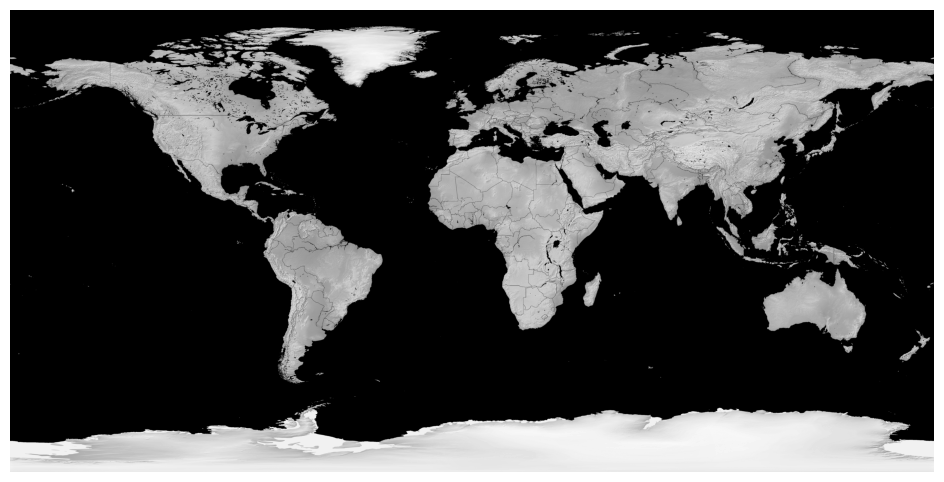

In [987]:
plt.figure(figsize=(12,6))
plt.imshow(base, cmap='gray')
plt.axis('off')

In [988]:
ds = nc.Dataset('../../UFZ_RemoteSensing/HOLAPS-H-JJA_anomaly-d-2001-2005.nc')
data = np.flip(ds["surface_upward_sensible_heat_flux"][0], axis=0)
lat_arr = ds['latitude'][:]
long_arr = ds['longitude'][:]
time_arr = ds['time'][:]
data.shape

(601, 1233)

In [989]:
## test dims
if not tile_start is None:
    data = data[-tile_HW[0]-tile_start:-tile_start,tile_start:tile_HW[1]+tile_start]
    lat_arr = lat_arr[tile_start:tile_HW[0]+tile_start]
    long_arr = long_arr[tile_start:tile_HW[1]+tile_start]
    
data.shape, lat_arr.shape, long_arr.shape

((601, 1233), (601,), (1233,))

In [990]:
def find_idx_nearest_val(arr, val):
    return (np.abs(arr - val)).argmin()

In [991]:
def get_world_part(world_map, lat_arr, long_arr):

    loc_lat = np.linspace(-90, 90, world_map.shape[0])
    loc_long = np.linspace(-180, 180, world_map.shape[1])

    min_lat = np.min(lat_arr)
    max_lat = np.max(lat_arr)
    min_long = np.min(long_arr)
    max_long = np.max(long_arr)

    world_max_lat_idx = find_idx_nearest_val(-loc_lat, min_lat)
    world_min_lat_idx = find_idx_nearest_val(-loc_lat, max_lat)

    world_min_long_idx = find_idx_nearest_val(loc_long, min_long)
    world_max_long_idx = find_idx_nearest_val(loc_long, max_long)

    return world_map[world_min_lat_idx:world_max_lat_idx, world_min_long_idx:world_max_long_idx]

In [992]:
base = get_world_part(base, lat_arr, long_arr)

In [993]:
base.shape

(642, 1325)

(-0.5, 1324.5, 641.5, -0.5)

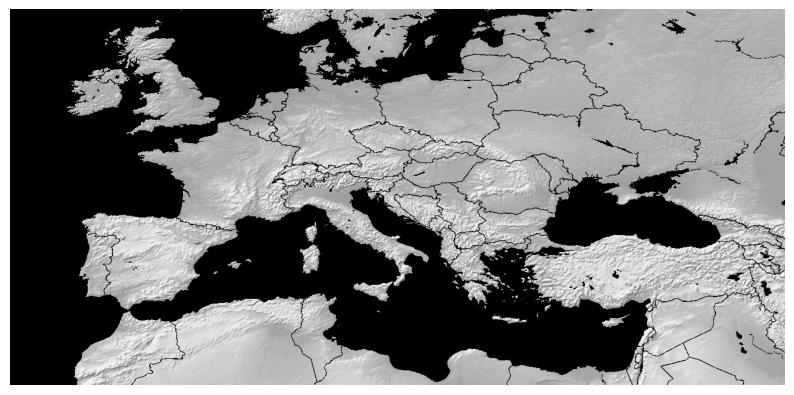

In [994]:
plt.figure(figsize=(10,5))
plt.imshow(base, cmap='gray')
plt.axis('off')

In [995]:
min_val = np.min(data)
max_val = np.max(data)
min_val, max_val

(-111.63459, 119.272026)

In [996]:
data = cv2.resize(data, base.shape[::-1], interpolation=cv2.INTER_NEAREST)

In [997]:
# ### Using the range from the array itself:
# # im not using np.ptp (peak-to-peak) becuase of the default -9999 value
# data_normed = (254*(data - min_val)/(max_val-min_val)).astype(int)+1
# data_normed[data_normed==np.min(data_normed)]=0

In [998]:
## should be set by the user:
data_range = (-150,150)

In [999]:
### Using the range from the array itself:
# im not using np.ptp (peak-to-peak) becuase of the default -9999 value
data_normed = (254*(data - data_range[0])/(data_range[1]-data_range[0])).astype(int)+1
data_normed[data_normed==np.min(data_normed)]=0

In [1000]:
colmap = cm.get_cmap('jet')
if isinstance(colmap, colors.LinearSegmentedColormap):
    colmap = (colmap(np.arange(0,colmap.N))*np.asarray([255,255,255,0.5*255]).astype(np.uint8))

for i in range(1,128):
    colmap[i,3] = 255-(i-1)*2
    colmap[256-i,3] = 255-(i-1)*2
    #print(i, 256-i, 255-(i-1)*2)
    
colmap[128,3] = 1
colmap[0, 3] = 0

result = np.zeros((*data_normed.shape,4), dtype=np.uint8)

data_w_cmap = np.take(colmap, data_normed, axis=0, out=result)

(-0.5, 1324.5, 641.5, -0.5)

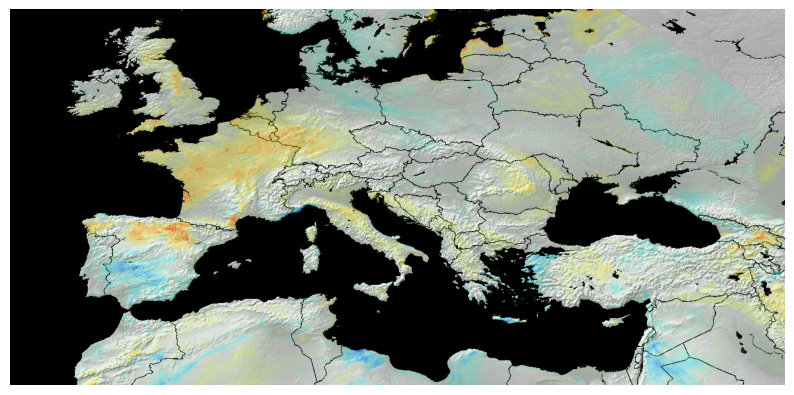

In [1001]:
fig = plt.figure(figsize=(10, 5))

plt.imshow(base, cmap='gray')
plt.imshow(data_w_cmap)
plt.axis('off')

#### Trying ovelay manually 
no need - do overlay in matplotlib below

In [1002]:
#base_as3D = np.concatenate((np.dstack([base]*3), np.full((*base.shape,1), 255, dtype=np.uint8)), axis=2)
### e.g. 642, 1325, 4

# plt.imshow(base_as3D)
# plt.imshow(data_w_cmap)

### Render 

In [1003]:
def format_date(date):
    date_obj = datetime.strptime(date, '%Y%m%d')
    return date_obj.strftime("%b %d, %Y")
    #return f'{date[6:8]}/{date[4:6]}/{date[:4]}'

In [1004]:
max_w = 3000
if base.shape[1]>max_w:
    h = round((max_w/base.shape[1]) * base.shape[0])
    base = cv2.resize(base, (max_w,h), interpolation=cv2.INTER_NEAREST)

In [1005]:
# def generate_legend(im_shape, date, cmap):
#     layer = np.zeros((*im_shape,4), dtype=np.uint8)
    
#     legend_size = [int(im_shape[0]/5.5),int(im_shape[0]/2.3)]
#     legend_margin = (5,5)
#     legend = np.ones((*legend_size,4), dtype=np.uint8) * np.asarray([0,0,0,255])
    
#     cube_size = int(legend_size[0]/2.5)
#     cube_start_y = legend_size[0]-cube_size-int(legend_size[0]/6.5)
#     ## first cube
#     legend[cube_start_y:cube_start_y+cube_size, 
#            legend_size[1]//2-cube_size*2:
#            legend_size[1]//2-cube_size] = colmap[1]
#     ## second cube
#     legend[cube_start_y:cube_start_y+cube_size, 
#            legend_size[1]//2-cube_size:
#            legend_size[1]//2] = colmap[63]
#     ## third cube
#     legend[cube_start_y:cube_start_y+cube_size, 
#            legend_size[1]//2:
#            legend_size[1]//2+cube_size] = colmap[191]
#     ## forth cube
#     legend[cube_start_y:cube_start_y+cube_size, 
#            legend_size[1]//2+cube_size:
#            legend_size[1]//2+cube_size*2] = colmap[-1]
    
#     layer[-legend_size[0]-legend_margin[0]:-legend_margin[0],
#           legend_margin[1]:legend_size[1]+legend_margin[1]] = legend
    
#     im = plt.imshow(layer, cmap='gray', alpha=0.8)
#     txt = plt.text(legend_margin[1]+(legend_size[0]//3), 
#                    layer.shape[0] - legend_margin[0] - int(legend_size[0]*3/4.5),
#                    f'{format_date(date)}',
#                    size=legend_size[0]//3,
#                    color='w')
    
#     txt1 = plt.text(legend_margin[1]+legend_size[1]//2-cube_size*2,
#                    layer.shape[0] - legend_margin[0] - cube_start_y+cube_size//2, 
#                    f'{data_range[1]}',
#                    size=legend_size[0]//5,
#                    color='w')
    
#     return im, txt, txt1

In [1006]:
def generate_legend(im_shape, date, cmap):
    layer = np.zeros((*im_shape,4), dtype=np.uint8)
    
    legend_size = [int(im_shape[0]/5.5),int(im_shape[0]/2.3)]
    legend_margin = (5,5)
    legend = np.ones((*legend_size,4), dtype=np.uint8) * np.asarray([0,0,0,255])
    
    cube_size = int(legend_size[0]/2.5)
    cube_start_y = legend_size[0]-cube_size-int(legend_size[0]/6.5)
    ## first cube
    legend[cube_start_y:cube_start_y+cube_size, 
           legend_size[1]//2-cube_size*2:
           legend_size[1]//2-cube_size] = colmap[1]
    ## second cube
    legend[cube_start_y:cube_start_y+cube_size, 
           legend_size[1]//2-cube_size:
           legend_size[1]//2] = colmap[63]
    ## third cube
    legend[cube_start_y:cube_start_y+cube_size, 
           legend_size[1]//2:
           legend_size[1]//2+cube_size] = colmap[191]
    ## forth cube
    legend[cube_start_y:cube_start_y+cube_size, 
           legend_size[1]//2+cube_size:
           legend_size[1]//2+cube_size*2] = colmap[-1]
    
    layer[-legend_size[0]-legend_margin[0]:-legend_margin[0],
          legend_margin[1]:legend_size[1]+legend_margin[1]] = legend
    
    im = plt.imshow(layer, cmap='gray', alpha=0.8)
    txt = plt.text(legend_margin[1]+(legend_size[0]//3), 
                   layer.shape[0] - legend_margin[0] - int(legend_size[0]*3/4.5),
                   f'{format_date(date)}',
                   size=legend_size[0]//3,
                   color='w')
    
    txt1 = plt.text(legend_margin[1]+legend_size[1]//2-cube_size*2,
                   layer.shape[0] - legend_margin[0] - cube_start_y+cube_size//2, 
                   f'{data_range[1]}',
                   size=legend_size[0]//5,
                   color='w')
    
    return im, txt, txt1

In [1009]:
def render_2d_scene(base, ds, i):
    data = np.flip(ds["surface_upward_sensible_heat_flux"][i], axis=0)
    
    ## take only a tile of the data
    if not tile_start is None:
        data = data[-tile_HW[0]-tile_start:-tile_start,tile_start:tile_HW[1]+tile_start]
    
    # resize:
    data = cv2.resize(data, base.shape[::-1], interpolation=cv2.INTER_NEAREST)
    
    # change colors according to cmap - so more middle more opacity
    data = (254*(data - data_range[0])/(data_range[1]-data_range[0])).astype(int)+1
    data[data==np.min(data)]=0
    # mask
    data[base==0] = 0
    # cmap
    data_w_cmap = np.take(colmap, data, axis=0, out=result)
    
    im1 = plt.imshow(base, cmap='gray', animated=True)
    im2 = plt.imshow(data_w_cmap, animated=True)
    
    ###### legend
    im_shape = base.shape
    legend_shape = [int(im_shape[0]/5.5),int(im_shape[0]/2.3)]
    margin = 10
    ax = plt.gca()
    rect = patches.FancyBboxPatch((margin, im_shape[0]-margin-legend_shape[0]), 
                                  legend_shape[1], legend_shape[0], 
                                  boxstyle=patches.BoxStyle("Round", pad=5), 
                                  facecolor='black', edgecolor='white', alpha=0.8)
    im3 = ax.add_patch(rect)
    
    ## add date
    cx = margin + legend_shape[1]//2
    cy = im_shape[0] - margin - legend_shape[0]//2
    qy = im_shape[0] - margin - int(legend_shape[0]/4*3)
    q3y = im_shape[0] - margin - int(legend_shape[0]/4)
    im4 = plt.annotate(f'{format_date(str(ds["time"][i])[:-2])}', 
                       (cx, qy), 
                       # xytext=(0,-30),
                       # textcoords="offset pixels",
                       color='white', fontsize=legend_shape[0]/3, 
                       ha='center', va='center')
    
    # add legend boxes
    box_size = legend_shape[0]//2
    basebox = patches.Rectangle((cx-2*box_size, q3y-box_size//2), 
                                  box_size*4, box_size, 
                                  facecolor='white')
    box1 = patches.Rectangle((cx-2*box_size, q3y-box_size//2), 
                                  box_size, box_size, 
                                  facecolor=colmap[1]/255.0)
    box2 = patches.Rectangle((cx-box_size, q3y-box_size//2), 
                              box_size, box_size, 
                              facecolor=colmap[85]/255.0)
    box3 = patches.Rectangle((cx, q3y-box_size//2), 
                                  box_size, box_size, 
                                  facecolor=colmap[170]/255.0)
    box4 = patches.Rectangle((cx+box_size, q3y-box_size//2), 
                                  box_size, box_size, 
                                  facecolor=colmap[255]/255.0)
    im5 = ax.add_patch(basebox)
    im6 = ax.add_patch(box1)
    im7 = ax.add_patch(box2)
    im8 = ax.add_patch(box3)
    im9 = ax.add_patch(box4)
    
    ## add text annotation to box:
    im10 = plt.annotate(data_range[0], 
                   (cx-int(1.5*box_size), q3y), 
                   # xytext=(0,-30),
                   # textcoords="offset pixels",
                   color='white', fontsize=legend_shape[0]/5, 
                   ha='center', va='center')
    ## add text annotation to box:
    im11 = plt.annotate(data_range[1], 
                   (cx+int(1.5*box_size), q3y), 
                   color='white', fontsize=legend_shape[0]/5, 
                   ha='center', va='center')
    
    
    #im3, im4, im5 = generate_legend(base.shape, str(ds["time"][i])[:-2], "jet")

    return [im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, im11]

<Figure size 640x480 with 0 Axes>

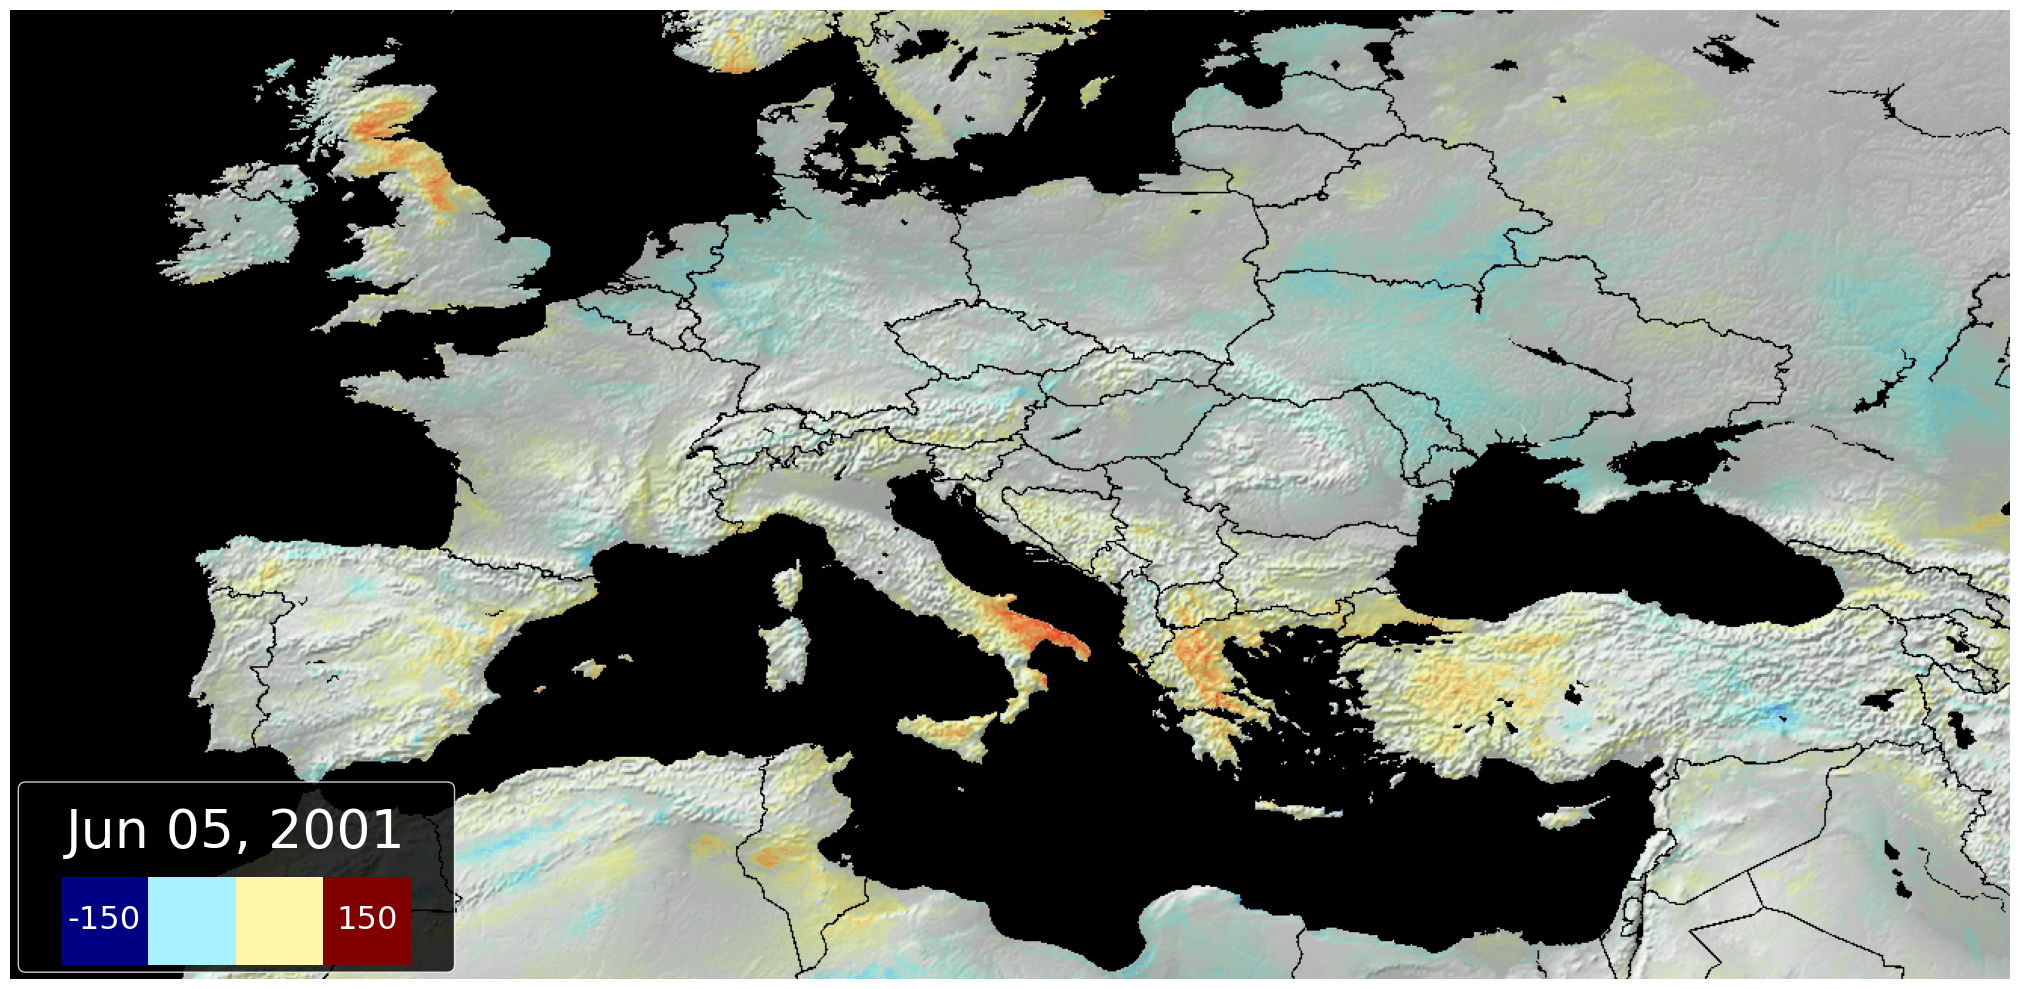

In [1011]:
fig = plt.figure()
fig = plt.figure(frameon=False)
plt.gca().set_axis_off()
# plt.margins(0,0)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
w = min(base.shape[1]//50, 20)
h = round((base.shape[0]/base.shape[1])*w)
fig.set_size_inches(w=w, h=h, forward=True)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(5):#range(time_arr.size):
    im = render_2d_scene(base, ds, i)    
    ims.append(im)
    #ann.remove()

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000,)

ani.save('dynamic_images1.mp4', savefig_kwargs={"pad_inches":0})

plt.show()